
# Importação de bibliotecas

In [55]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from classifiers.bayesian_classifier_discriminant import BayesianGaussianDiscriminant
from utils.classifier_utils import ClassifierUtils
from utils.dataset_utils import DatasetUtils
from utils.image_generator import ImageGenerator
import category_encoders as ce

# Definição de constantes

In [56]:
np.random.seed(42)
CLASSIFIER_NAME = "Bayesian Gaussian Discriminant"
TARGET_COLUMN_NAME = "Class"
DATASET_NAME = "Breast Cancer"
ACTIVITY_NUMBER = 4
TEST_SIZE = 0.2
HOLDOUT_INDEXES_NUMBER = 200
FIG_SIZE = (12, 10)
IMAGE_FONT_SIZE = 20
RESOLUTION_POINTS = 1000

# Baixando dataset Iris

In [57]:
breast_cancer = fetch_ucirepo(id=14)

X_breast_cancer = breast_cancer.data.features
y_breast_cancer = breast_cancer.data.targets

breast_cancer_df = pd.concat([X_breast_cancer, y_breast_cancer], axis="columns")

In [58]:
list(breast_cancer_df[TARGET_COLUMN_NAME].unique())

['no-recurrence-events', 'recurrence-events']

# Redefinindo classes para valores numéricos

In [59]:
class_mapping = {"no-recurrence-events": 0, "recurrence-events": 1}
breast_cancer_df[TARGET_COLUMN_NAME] = breast_cancer_df[TARGET_COLUMN_NAME].map(
    class_mapping
)
breast_cancer_df[TARGET_COLUMN_NAME]

0      0
1      0
2      0
3      0
4      0
      ..
281    1
282    1
283    1
284    1
285    1
Name: Class, Length: 286, dtype: int64

# Identificando valores categóricos

In [60]:
categorical_columns = breast_cancer_df.select_dtypes(
    include=["object", "category"]
).columns
categorical_columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast',
       'breast-quad', 'irradiat'],
      dtype='object')

# Encoding de variáveis categóricas

In [61]:
encoder = ce.TargetEncoder(cols=categorical_columns)
breast_cancer_df_encoded = encoder.fit_transform(
    breast_cancer_df[categorical_columns], breast_cancer_df[TARGET_COLUMN_NAME]
)

breast_cancer_df_encoded

,age,menopause,tumor-size,inv-nodes,node-caps,breast,breast-quad,irradiat
0,0.396599,0.320000,0.414518,0.215962,0.22973,0.322368,0.318179,0.247706
1,0.299997,0.320000,0.318919,0.215962,0.22973,0.268657,0.373222,0.247706
2,0.299997,0.320000,0.318919,0.215962,0.22973,0.322368,0.318179,0.247706
3,0.298220,0.271318,0.250510,0.215962,0.22973,0.268657,0.268054,0.247706
4,0.299997,0.320000,0.257342,0.215962,0.22973,0.268657,0.268943,0.247706
...,...,...,...,...,...,...,...,...
281,0.396599,0.320000,0.414518,0.215962,0.22973,0.322368,0.268054,0.247706
282,0.396599,0.320000,0.318919,0.215962,0.22973,0.322368,0.268054,0.454587
283,0.298220,0.271318,0.318919,0.215962,0.22973,0.268657,0.268054,0.247706
284,0.299997,0.271318,0.414518,0.442822,0.22973,0.322368,0.318179,0.247706


In [62]:
breast_cancer_df_encoded_final = pd.concat(
    [breast_cancer_df_encoded, breast_cancer_df.drop(columns=categorical_columns)],
    axis="columns",
)

In [63]:
breast_cancer_df_encoded_final

,age,menopause,tumor-size,inv-nodes,node-caps,breast,breast-quad,irradiat,deg-malig,Class
0,0.396599,0.320000,0.414518,0.215962,0.22973,0.322368,0.318179,0.247706,3,0
1,0.299997,0.320000,0.318919,0.215962,0.22973,0.268657,0.373222,0.247706,2,0
2,0.299997,0.320000,0.318919,0.215962,0.22973,0.322368,0.318179,0.247706,2,0
3,0.298220,0.271318,0.250510,0.215962,0.22973,0.268657,0.268054,0.247706,2,0
4,0.299997,0.320000,0.257342,0.215962,0.22973,0.268657,0.268943,0.247706,2,0
...,...,...,...,...,...,...,...,...,...,...
281,0.396599,0.320000,0.414518,0.215962,0.22973,0.322368,0.268054,0.247706,2,1
282,0.396599,0.320000,0.318919,0.215962,0.22973,0.322368,0.268054,0.454587,3,1
283,0.298220,0.271318,0.318919,0.215962,0.22973,0.268657,0.268054,0.247706,1,1
284,0.299997,0.271318,0.414518,0.442822,0.22973,0.322368,0.318179,0.247706,3,1


# Treinamento e avaliação dos modelos, juntamente com a criação de tabela de métricas para o classificador Naive Bayes

In [64]:
naive_bayesian_holdout_indexes = ClassifierUtils.create_multiple_holdout_indexes(
    df=breast_cancer_df_encoded_final,
    n_indexes=HOLDOUT_INDEXES_NUMBER,
    test_size=TEST_SIZE,
)

naive_bayesian_accuracy_list = []

for train_indexes, test_indexes in naive_bayesian_holdout_indexes:
    X_train, y_train, X_test, y_test = ClassifierUtils.separate_train_test(
        df=breast_cancer_df_encoded_final,
        train_indexes=train_indexes,
        test_indexes=test_indexes,
        target_column_name=TARGET_COLUMN_NAME,
    )

    classifier = BayesianGaussianDiscriminant(discriminant_type="linear")
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test=X_test)

    accuracy = ClassifierUtils.calculate_accuracy(y_true=y_test, y_pred=y_pred)
    error_rate = ClassifierUtils.calculate_error_rate(y_true=y_test, y_pred=y_pred)

    confusion_matrix_result = ClassifierUtils.confusion_matrix(
        y_true=y_test, y_pred=y_pred
    )

    naive_bayesian_accuracy_list.append(
        (
            accuracy,
            error_rate,
            train_indexes,
            test_indexes,
            y_pred,
            confusion_matrix_result,
        )
    )

naive_bayesian_df_results = pd.DataFrame(
    naive_bayesian_accuracy_list,
    columns=[
        "accuracy",
        "error_rate",
        "train_indexes",
        "test_indexes",
        "y_pred",
        "confusion_matrix",
    ],
)

naive_bayesian_df_results

,accuracy,error_rate,train_indexes,test_indexes,y_pred,confusion_matrix
0,0.736842,0.263158,"[9, 267, 143, 212, 227, 155, 283, 73, 196, 33, 185, 124, 146, 265, 5, 220, 233, 251, 45, 268, 170, 56, 200, 79, 111, 275, 274, 217, 109, 42, 203, 84, 269, 93, 46, 204, 63, 75, 240, 164, 181, 30, 22, 24, 175, 77, 147, 221, 249, 92, 207, 234, 177, 211, 6, 116, 193, 60, 139, 25, 82, 144, 66, 246, 19, 90, 250, 15, 10, 68, 165, 37, 16, 154, 258, 67, 113, 112, 255, 117, 202, 159, 18, 120, 219, 86, 125, 101, 184, 55, 114, 224, 38, 173, 97, 57, 108, 272, 206, 148, ...]","[129, 130, 131, 257, 259, 134, 7, 8, 260, 262, 13, 270, 17, 273, 20, 21, 149, 151, 280, 285, 160, 34, 166, 169, 171, 174, 48, 50, 52, 54, 58, 59, 187, 188, 189, 191, 198, 71, 72, 205, 80, 83, 214, 87, 88, 89, 91, 99, 228, 102, 106, 235, 110, 241, 243, 121, 252]","[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0]","[[35, 7], [8, 7]]"
1,0.701754,0.298246,"[257, 106, 135, 101, 87, 130, 132, 109, 27, 70, 163, 195, 268, 196, 83, 13, 186, 272, 58, 250, 244, 165, 259, 41, 29, 251, 120, 80, 139, 284, 2, 76, 8, 44, 20, 231, 197, 233, 10, 81, 6, 40, 137, 55, 148, 209, 167, 221, 153, 236, 202, 73, 74, 267, 78, 246, 30, 282, 216, 166, 43, 82, 86, 39, 71, 279, 161, 99, 210, 111, 122, 72, 131, 269, 204, 11, 79, 185, 1, 241, 158, 264, 266, 245, 138, 258, 90, 156, 133, 110, 9, 140, 277, 208, 84, 215, 242, 155, 112, 239, ...]","[256, 3, 5, 134, 263, 16, 17, 146, 273, 276, 21, 278, 23, 24, 26, 283, 157, 159, 32, 160, 34, 36, 37, 168, 171, 45, 175, 48, 50, 180, 53, 187, 190, 191, 66, 67, 194, 207, 212, 214, 219, 92, 94, 222, 96, 224, 98, 225, 229, 232, 237, 240, 115, 116, 123, 253, 127]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]","[[36, 3], [14, 4]]"
2,0.666667,0.333333,"[245, 92, 149, 178, 106, 137, 96, 254, 109, 230, 208, 39, 42, 47, 127, 258, 21, 115, 192, 255, 183, 276, 124, 83, 219, 175, 17, 129, 226, 86, 278, 78, 99, 110, 161, 268, 153, 30, 206, 103, 157, 12, 1, 197, 88, 204, 66, 224, 119, 259, 250, 210, 128, 243, 211, 269, 67, 270, 122, 139, 156, 14, 23, 138, 262, 282, 266, 225, 176, 231, 102, 63, 37, 123, 74, 65, 248, 200, 271, 105, 274, 265, 87, 95, 168, 49, 182, 202, 93, 186, 218, 71, 120, 33, 31, 249, 61, 3, 76, 232, ...]","[131, 4, 132, 6, 135, 8, 136, 267, 140, 143, 144, 145, 272, 150, 24, 281, 26, 283, 28, 285, 162, 35, 164, 165, 38, 167, 41, 169, 44, 173, 177, 51, 52, 180, 56, 185, 64, 193, 68, 69, 70, 73, 75, 205, 82, 85, 214, 216, 220, 222, 98, 229, 234, 108, 238, 121, 252]","[1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[[36, 7], [12, 2]]"
3,0.684211,0.315789,"[263, 91, 157, 60, 142, 216, 81, 214, 127, 236, 124, 259, 103, 114, 15, 45, 222, 277, 169, 105, 174, 200, 121, 159, 57, 260, 134, 218, 86, 80, 95, 160, 148, 109, 122, 171, 47, 42, 235, 40, 173, 115, 152, 1, 11, 220, 49, 166, 234, 79, 158, 51, 23, 44, 250, 229, 199, 175, 70, 53, 170, 147, 221, 113, 155, 90, 193, 202, 73, 56, 97, 177, 265, 26, 254, 28, 140, 161, 106, 102, 255, 268, 244, 195, 176, 87, 101, 98, 52, 248, 194, 143, 247, 262, 146, 22, 96, 165, 50, 31, ...]","[256, 2, 6, 7, 264, 137, 266, 12, 13, 14, 144, 145, 274, 275, 276, 24, 25, 153, 27, 282, 283, 33, 38, 167, 168, 41, 43, 179, 55, 186, 191, 66, 67, 201, 77, 206, 82, 211, 85, 213, 215, 217, 226, 227, 230, 232, 108, 237, 110, 238, 112, 240, 118, 251, 252, 125, 126]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]","[[31, 3], [15, 8]]"
4,0.666667,0.333333,"[180, 15, 277, 22, 14, 12, 47, 126, 257, 217, 267, 67, 158, 168, 242, 82, 68, 78, 51, 27, 49, 60, 59, 170, 169

# Vetor de acurácias

In [65]:
naive_bayesian_accuracy_vector = pd.Series(naive_bayesian_df_results["accuracy"])

In [66]:
naive_bayesian_accuracy_vector

0      0.736842
1      0.701754
2      0.666667
3      0.684211
4      0.666667
         ...   
195    0.701754
196    0.666667
197    0.649123
198    0.684211
199    0.719298
Name: accuracy, Length: 200, dtype: float64

# Definindo gerador de imagens

In [67]:
image_generator = ImageGenerator(figure_size=FIG_SIZE, font_size=IMAGE_FONT_SIZE)

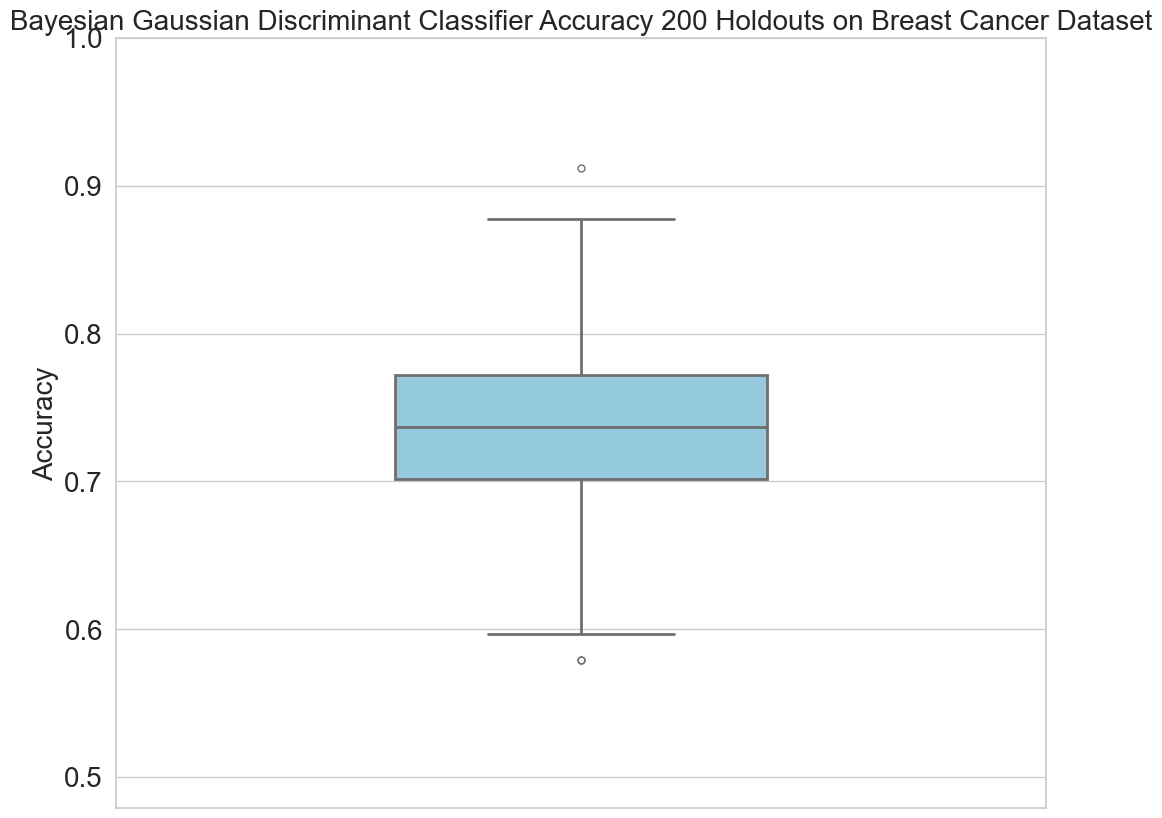

In [68]:
image_type = "boxplot"

image_generator.create_boxplot(
    vector_distribution=naive_bayesian_accuracy_vector,
    y_label="Accuracy",
    image_title=f"{CLASSIFIER_NAME} Classifier Accuracy {HOLDOUT_INDEXES_NUMBER} Holdouts on {DATASET_NAME} Dataset",
    path_to_save=f"../../data/images/atividade_{ACTIVITY_NUMBER}/{DATASET_NAME.lower()}_{CLASSIFIER_NAME.replace(' ', '_').lower()}_{image_type.lower()}.jpeg",
    show=True,
)

# Baseado na melhor acurácia, pego os índices de treino e teste que geraram ela e calculo a superfície de decisão e também resgato a sua respectiva matriz de confusão

In [69]:
max_accuracy = naive_bayesian_df_results["accuracy"].max()
indexes_of_max_accuracy = naive_bayesian_df_results[
    naive_bayesian_df_results["accuracy"] == max_accuracy
].index.tolist()

index_selected = np.random.choice(indexes_of_max_accuracy)

print(f"Índice(s) com melhor acurácia: {indexes_of_max_accuracy}")
print(f"Índice selecionado aleatoriamente: {index_selected}")
print(f"Acurácia do índice selecionado: {max_accuracy * 100:.2f}%")

best_accuracy_train_indexes = naive_bayesian_df_results.loc[
    index_selected, "train_indexes"
]
best_accuracy_test_indexes = naive_bayesian_df_results.loc[
    index_selected, "test_indexes"
]

X_train, y_train, X_test, y_test = ClassifierUtils.separate_train_test(
    df=breast_cancer_df_encoded_final,
    train_indexes=best_accuracy_train_indexes,
    test_indexes=best_accuracy_test_indexes,
    target_column_name=TARGET_COLUMN_NAME,
)

Índice(s) com melhor acurácia: [89]
Índice selecionado aleatoriamente: 89
Acurácia do índice selecionado: 91.23%


# Resgatando a matriz de confusão e plotando ela

In [70]:
confusion_matrix_result = naive_bayesian_df_results.loc[
    index_selected, "confusion_matrix"
]

In [71]:
confusion_matrix_result

array([[43,  1],
       [ 4,  9]])

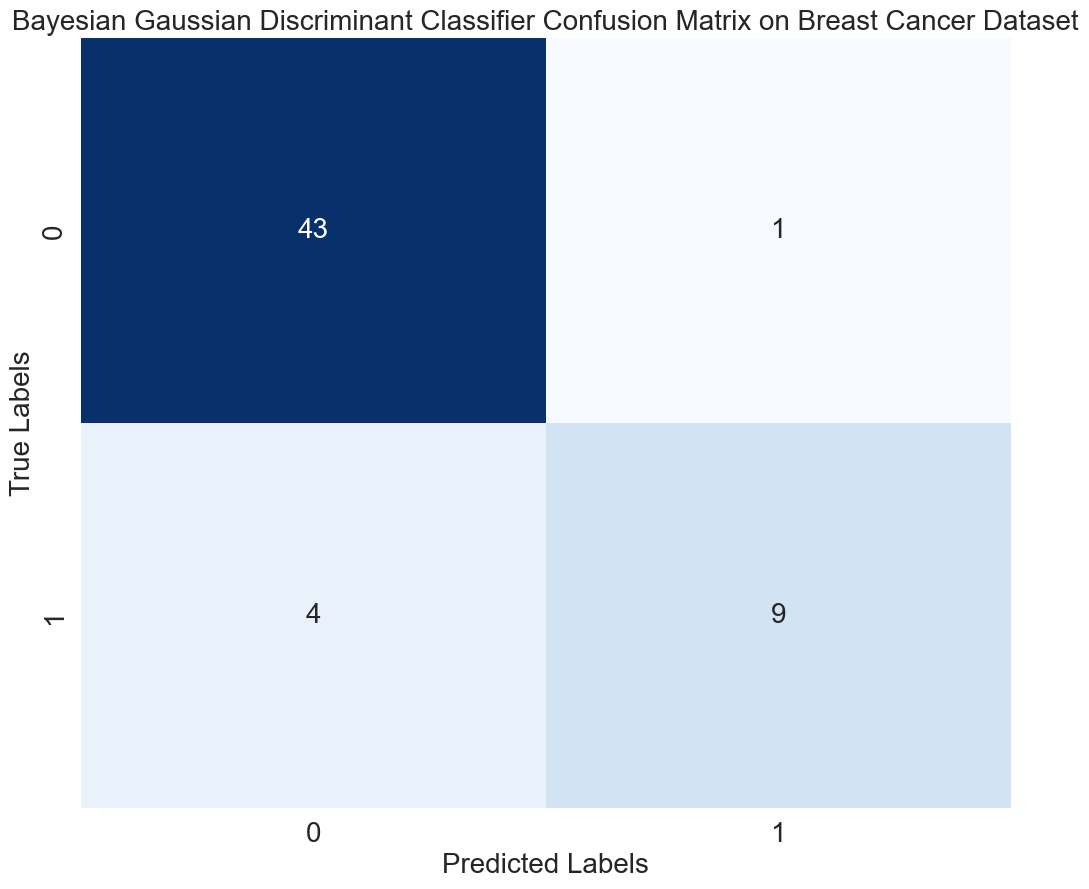

In [72]:
image_type = "confusion_matrix"

image_generator.create_confusion_matrix_heatmap(
    confusion_matrix=confusion_matrix_result,
    x_label="Predicted Labels",
    y_label="True Labels",
    image_title=f"{CLASSIFIER_NAME} Classifier Confusion Matrix on {DATASET_NAME} Dataset",
    path_to_save=f"../../data/images/atividade_{ACTIVITY_NUMBER}/{DATASET_NAME.lower()}_{CLASSIFIER_NAME.replace(' ', '_').lower()}_{image_type.lower()}.jpeg",
    show=True,
)

# Calculo de superfície de decisão para o classificador Naive Bayes baseado em duas features

In [73]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

test_grid, x_shape, y_shape = DatasetUtils.create_test_grid(
    X_train=X_train,
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    return_shapes=True,
)

classifier = BayesianGaussianDiscriminant(discriminant_type="linear")
classifier.fit(X_train[[feature_x, feature_y]], y_train)

y_pred_test_grid = classifier.predict(test_grid)

y_pred_test_grid = y_pred_test_grid.reshape(x_shape)

# Plot da superfície de decisão para o classificador Naive Bayes

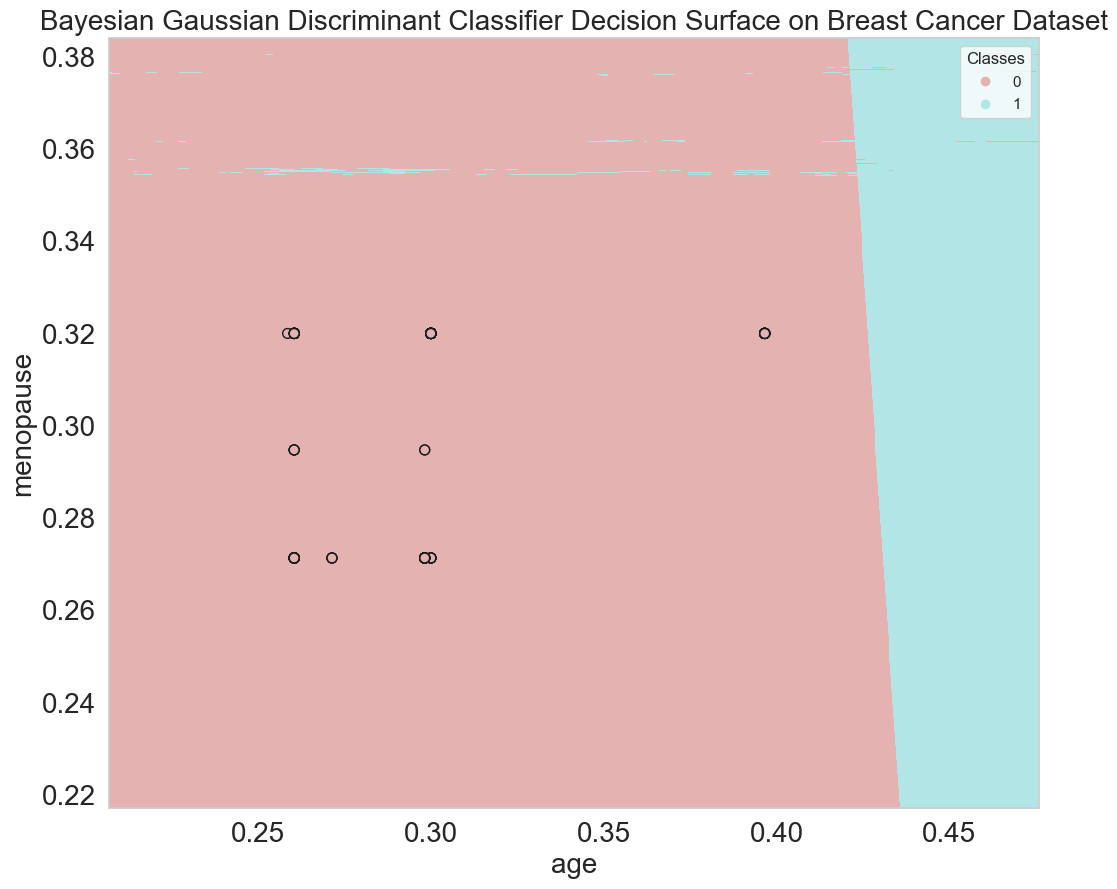

In [74]:
image_type = "decision_surface_linear"

image_generator.create_decision_surface(
    X_train=X_train,
    y_train=y_train,
    y_pred=y_pred_test_grid,
    image_title=f"{CLASSIFIER_NAME} Classifier Decision Surface on {DATASET_NAME} Dataset",
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    path_to_save=f"../../data/images/atividade_{ACTIVITY_NUMBER}/{DATASET_NAME.lower()}_{CLASSIFIER_NAME.replace(' ', '_').lower()}_{image_type.lower()}.jpeg",
    num_classes=len(np.unique(y_train)),
    show=True,
)

In [75]:
feature_x = X_train.columns[0]
feature_y = X_train.columns[1]

test_grid, x_shape, y_shape = DatasetUtils.create_test_grid(
    X_train=X_train,
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    return_shapes=True,
)

classifier = BayesianGaussianDiscriminant(discriminant_type="quadratic")
classifier.fit(X_train[[feature_x, feature_y]], y_train)

y_pred_test_grid = classifier.predict(test_grid)

y_pred_test_grid = y_pred_test_grid.reshape(x_shape)

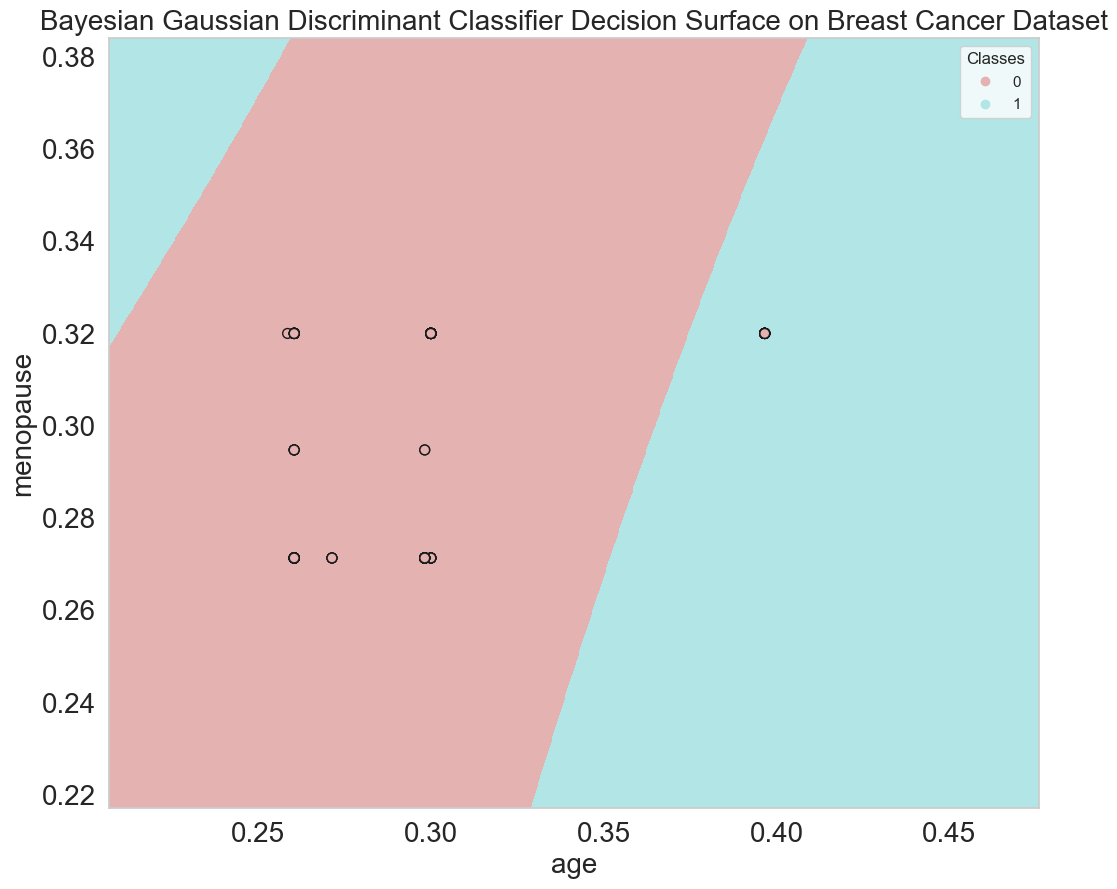

In [76]:
image_type = "decision_surface_quadratic"

image_generator.create_decision_surface(
    X_train=X_train,
    y_train=y_train,
    y_pred=y_pred_test_grid,
    image_title=f"{CLASSIFIER_NAME} Classifier Decision Surface on {DATASET_NAME} Dataset",
    feature_x=feature_x,
    feature_y=feature_y,
    resolution_points=RESOLUTION_POINTS,
    path_to_save=f"../../data/images/atividade_{ACTIVITY_NUMBER}/{DATASET_NAME.lower()}_{CLASSIFIER_NAME.replace(' ', '_').lower()}_{image_type.lower()}.jpeg",
    num_classes=len(np.unique(y_train)),
    show=True,
)